# Analyze categorical RBM

In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt
os.chdir("../")
from h5py import File
import torch

from rbm.custom_fn import one_hot, compute_U
from rbm.utils import get_eigenvalues_hystory, get_checkpoints
from rbm.dataset import DatasetRBM
from rbm.plot import plot_PCA
from rbm.io import load_params
from rbm.potts.sampling import sample_state
from rbm.potts.functions import init_chains
from rbm.potts.analysis import get_correlation_two_points, get_freq_single_point, get_freq_two_points

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(f"Found device: {device}")

Found device: cuda


Uncomment if LaTeX is installed in the machine

In [3]:
# use LaTeX fonts in the plots
# plt.rcParams['mathtext.fontset'] = 'stix'
# plt.rcParams['font.family'] = 'STIXGeneral'
# plt.rcParams.update({'font.size': 15})
# plt.rcParams['text.usetex'] = True
# plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

Path to the data file and the RBM model

In [4]:
fname_data = "data/PF00072.fasta"
fname_model = "models/RBM_PF00072.h5"

#### Load data

In [5]:
dataset = DatasetRBM(
    path_data=fname_data,
    alphabet="protein",
    compute_weights=True,
    device=device
)

num_states = dataset.get_num_states()
num_visibles = dataset.get_num_visibles()
num_data = dataset.__len__()

data_oh = one_hot(dataset.data, num_classes=num_states).reshape(num_data, -1)
weights = dataset.weights

Automatically computing the sequence weights...


#### Load model

In [6]:
f = File(fname_model, "r")
for key in f["hyperparameters"].keys():
    print(key, f["hyperparameters"][key][()])
num_hiddens = f["hyperparameters"]["num_hiddens"][()]
chains = torch.tensor(f["parallel_chains"][()], device=device)
f.close()

batch_size 5000
gibbs_steps 10
learning_rate 0.01
num_chains 5000
num_hiddens 500
num_visibles 112
training_mode b'PCD'


Visualization of the weight matrix's eigenvalues as a function of the training time

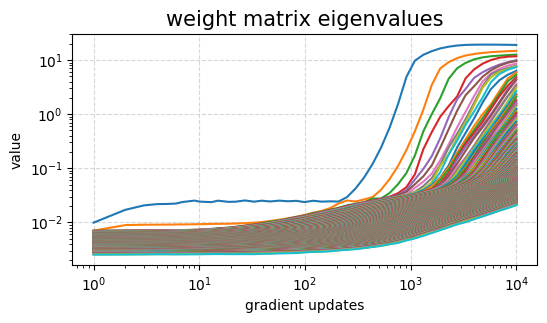

In [7]:
updates, eigenvalues = get_eigenvalues_hystory(fname_model)

fig, ax = plt.subplots(dpi=100, nrows=1, ncols=1, figsize=(6, 3))
ax.set_title('weight matrix eigenvalues', size=15)
ax.set_xlabel('gradient updates')
ax.set_ylabel('value')
ax.set_xscale('log')
ax.set_yscale('log')
ax.grid(alpha=0.5, ls='dashed')
ax.plot(updates, eigenvalues);

#### Visualize training chains versus data

In [8]:
num_chains = len(chains)

U = compute_U(
    M=data_oh - data_oh.mean(0),
    d=4,
    weights=weights,
    device=device,
    dtype=torch.float32
)
data_proj = data_oh @ U / num_visibles**0.5

chains_oh = one_hot(chains, num_classes=num_states).reshape(num_chains, -1)
chains_proj = chains_oh @ U / num_visibles**0.5

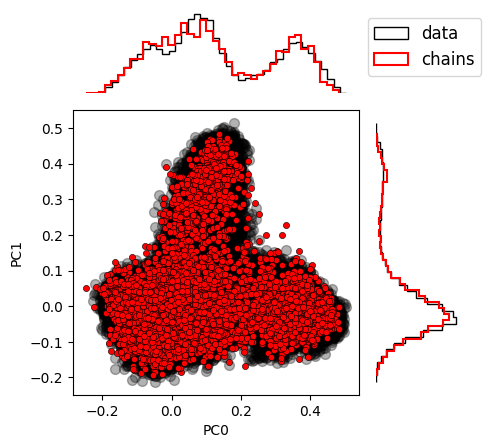

In [9]:
plot_PCA(data_proj.cpu().numpy(), chains_proj.cpu().numpy(), labels=["data", "chains"], dir1=0, dir2=1)

Compute the Pearson correlation coefficient on the covariance matrix of the training chains versus the data

In [10]:
fi = get_freq_single_point(
    data=data_oh.reshape(len(data_oh), num_visibles, num_states)[:num_chains],
    weights=weights[:num_chains],
    pseudo_count=0.
)

pi = get_freq_single_point(
    data=chains_oh.reshape(num_chains, num_visibles, num_states),
    weights=None,
    pseudo_count=0.
)

fij = get_freq_two_points(
    data=data_oh.reshape(len(data_oh), num_visibles, num_states)[:num_chains],
    weights=weights[:num_chains],
    pseudo_count=0.
)

pij = get_freq_two_points(
    data=chains_oh.reshape(num_chains, num_visibles, num_states),
    weights=None,
    pseudo_count=0.
)

pearson_chains = get_correlation_two_points(
    fij=fij,
    pij=pij,
    fi=fi,
    pi=pi
).cpu().numpy()

print(f"Pearson chains: {pearson_chains}")

Pearson chains: 0.8864840269088745


### Generate data

In [11]:
n_gen = 5000
mcmc_steps = 10000
checkpoint = get_checkpoints(fname_model)[-1]

params = load_params(fname=fname_model, device=device, checkpoint=checkpoint)
chains_init = init_chains(num_chains=n_gen, num_visibles=num_visibles, num_hiddens=num_hiddens, num_colors=num_states, device=device)

gen = sample_state(chains=chains_init, params=params, gibbs_steps=mcmc_steps)["v"]
gen_oh = one_hot(gen, num_classes=num_states).reshape(n_gen, -1)
gen_proj = gen_oh @ U / num_visibles**0.5

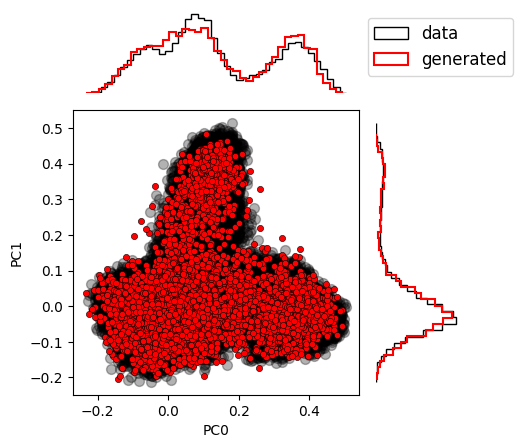

In [12]:
plot_PCA(data_proj.cpu().numpy(), gen_proj.cpu().numpy(), labels=["data", "generated"], dir1=0, dir2=1)

Compute the Pearson correlation coefficient on the covariance matrix of the generated samples versus the data

In [13]:
fi = get_freq_single_point(
    data=data_oh.reshape(len(data_oh), num_visibles, num_states)[:n_gen],
    weights=weights[:n_gen],
    pseudo_count=0.
)

pi = get_freq_single_point(
    data=gen_oh.reshape(n_gen, num_visibles, num_states),
    weights=None,
    pseudo_count=0.
)

fij = get_freq_two_points(
    data=data_oh.reshape(len(data_oh), num_visibles, num_states)[:n_gen],
    weights=weights[:n_gen],
    pseudo_count=0.
)

pij = get_freq_two_points(
    data=gen_oh.reshape(n_gen, num_visibles, num_states),
    weights=None,
    pseudo_count=0.
)

pearson_gen = get_correlation_two_points(
    fij=fij,
    pij=pij,
    fi=fi,
    pi=pi
).cpu().numpy()

print(f"Pearson generated: {pearson_gen}")

Pearson generated: 0.8837057948112488
